# Finding Donors for Charity
## Machine Learning (Supervised): Classification

### Description

This project will employ several supervised algorithms to accurately model individuals income using data collected from the 1994 U.S. Census. The best algorithm from preliminary results will be further optimized for the best model of the data. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  

### Project Goals
- **Target: Which potential donors make over $50,000?**
- How to identify when preprocessing is needed, and how to apply it.
- How to establish a benchmark for a solution to the problem.
- What each of several supervised learning algorithms accomplishes given a specific dataset.
- How to investigate whether a candidate solution model is adequate for the problem


### Reference
ref: Kohavi, [Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf)

### Data Source
ref: [Charity ML Dataset](https://archive.ics.uci.edu/ml/datasets/Census+Income)

## Load Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

from time import time
from IPython.display import display 
from tensorflow.python.client import device_lib

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, ShuffleSplit, train_test_split
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV

import seaborn as sns
sns.set(style="dark")
sns.set(font_scale=1.5)

%matplotlib inline

#import visuals as vs
%run ./visuals.py

print('Python:',sys.version)
print ('GPU:',device_lib.list_local_devices()[1].physical_device_desc,device_lib.list_local_devices()[1].name)

Python: 3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]
GPU: device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1 /device:GPU:0


## Data Summary

In [2]:
df = pd.read_csv("census.csv")
y_raw = df['income']
X_raw = df.drop('income', axis = 1)

print('Dataframe Shape:',df.shape)
display(df.head())
display(df.describe())
display(df.dtypes)

Dataframe Shape: (45222, 14)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


age                  int64
workclass           object
education_level     object
education-num      float64
marital-status      object
occupation          object
relationship        object
race                object
sex                 object
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country      object
income              object
dtype: object

In [3]:
n_records = len(df)
n_greater_50k = df[df['income'] == '>50K'].shape[0]
n_at_most_50k = df[df['income'] == '<=50K'].shape[0]
greater_percent = (n_greater_50k / n_records) * 100

print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


## Exploratory Visualization

### Scatter Matrix

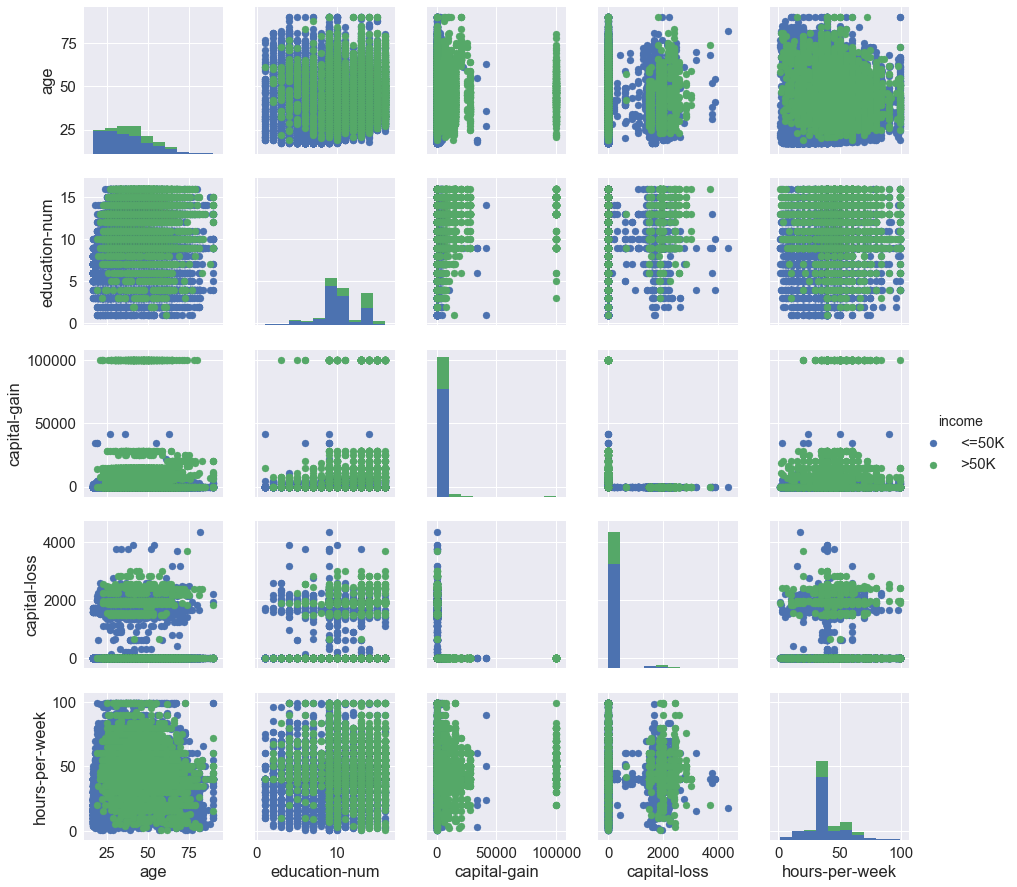

In [4]:
g = sns.PairGrid(df, hue="income")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

### Kernel Density Estimation Plots

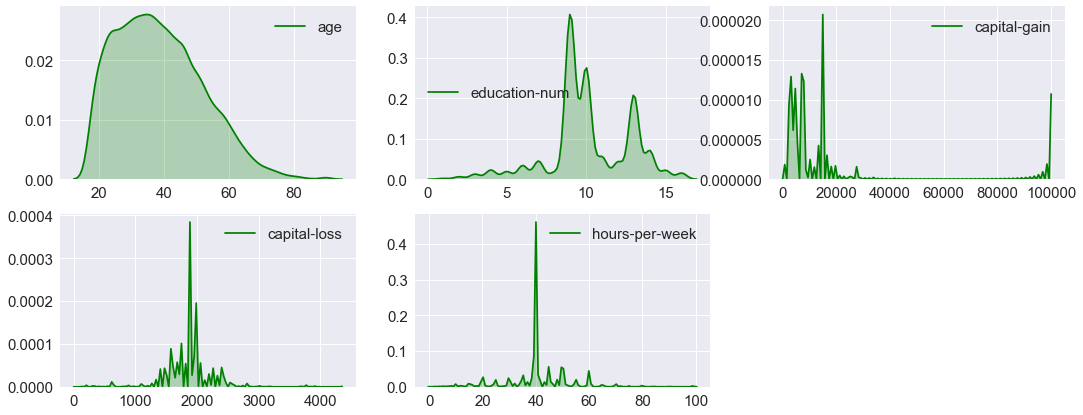

In [5]:
num_columns = df.select_dtypes(exclude=['object']).columns
fig = plt.figure(figsize=(18,7))
for i, col in enumerate(num_columns):
    fig.add_subplot(2, 3, i+1)
    sns.kdeplot(df[col], shade=True, color='g')
plt.show()

## Preprocessing

### Transforming Skewed Continuous Features

,after,before
age,0.532816,0.532816
education-num,-0.310621,-0.310621
capital-gain,3.082386,11.789002
capital-loss,4.271195,4.516304
hours-per-week,0.340545,0.340545


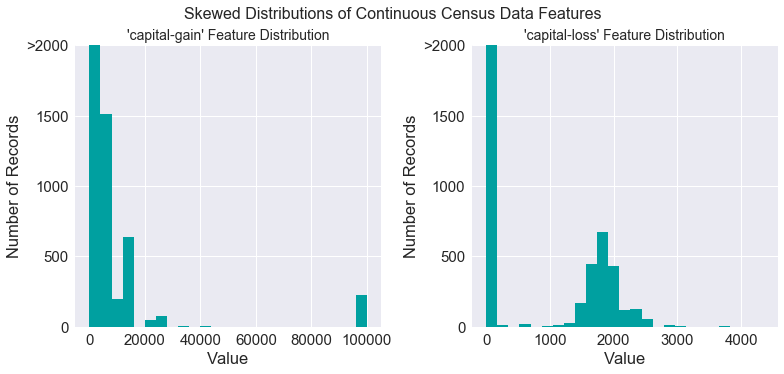

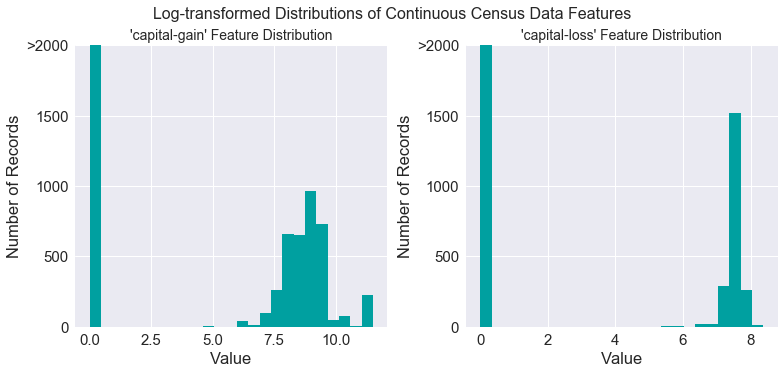

In [6]:
skewed = ['capital-gain', 'capital-loss']

X_log_transformed = X_raw.copy(deep=True)
X_log_transformed[skewed] = X_log_transformed[skewed].apply(lambda x: np.log(x + 1))

distribution(X_raw[skewed])
distribution(X_log_transformed[skewed], transformed = True)
display(pd.DataFrame({'before': X_raw.skew(), 'after': X_log_transformed.skew()}))

#X_raw.loc[0, 'age'] = 99

### Normalizing Numerical Features

In [7]:
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

scaler = MinMaxScaler()
X_log_minmax_transform = X_log_transformed.copy(deep = True)
X_log_minmax_transform[numerical] = scaler.fit_transform(X_log_transformed[numerical])

#display(X_log_minmax_transform.head())
#display(X_log_minmax_transform.describe())

### Converting Categorical Features using One Hot Encoding and Lambda Function

In [8]:
X = pd.get_dummies(X_log_minmax_transform)
y = y_raw.apply(lambda x: 1 if x == '>50K' else 0)

#from sklearn.preprocessing import LabelEncoder
#encoder = LabelEncoder()
#income = encoder.fit_transform(income_raw)

print('Dataframe Shape (after encoding):',X.shape,'\n')
#for feat in X_final.columns: print (feat)

print(y.value_counts())

Dataframe Shape (after encoding): (45222, 103) 

0    34014
1    11208
Name: income, dtype: int64


### Shuffle and Split Data into Training and Testing Datasets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print ('Dataframe Shape (Training):',X_train.shape, y_train.shape)
print ('Dataframe Shape (Testing):',X_test.shape, y_test.shape)

Dataframe Shape (Training): (36177, 103) (36177,)
Dataframe Shape (Testing): (9045, 103) (9045,)


## Model Performance

The model's ability to **precisely** predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals.

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

When $\beta = 0.5$, more emphasis is placed on **precision**. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

** Note: **The purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

### Performance Metric: fbeta_score (beta = 0.5)

In [10]:
scoring = make_scorer(fbeta_score, beta=0.5)

TP = np.sum(y)
FP = y.count() - TP
TN = 0
FN = 0

accuracy = TP / (TP + FP)
recall = TP / (TP + FN)
precision = TP / (TP + FP)
beta = 0.5
fscore = (1 + beta**2) * ((precision * recall) / ((beta**2 * precision) + recall))

### Naive Predictor: Benchmark for Results

In [11]:
y_pred = y.apply(lambda x: 1) # naive prediction ==> benchmark for results
#y_pred = [1 for i in range(len(y))] 

print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Naive Bayes

- **This is a quick first pass with a simple model**
- application (real world):  spam detection
- strengths: very fast, handles large datasets with lots of noise
- weaknesses: asssumes all features independently contribute to probabilities
- ref: [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)

### Random Forest Classifier

- **This model should provide solid results**
- application (real world):  predicting behavior in e-commerce
- strengths: very good for high dimensional spaces and robust to outliers
- weaknesses: structure of the results is difficult to interpret
- ref: [Random Forest Classifier](https://en.wikipedia.org/wiki/Random_forest)

### Gradient Boosting Classifier

- **This model should provide even better results with increased training time**
- application (real world):  predicting behavior in medicine
- strengths: generally higher accuracy than random forest
- weaknesses: much more computationally expensive
- ref: [Gradient Boosting Classifier](https://en.wikipedia.org/wiki/Gradient_boosting)

## Learning Curve

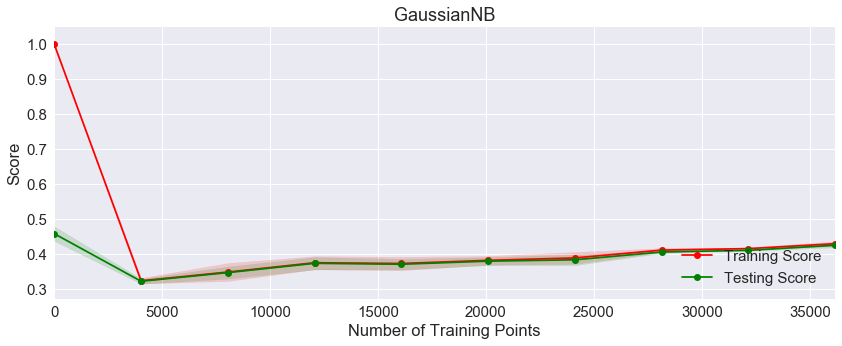

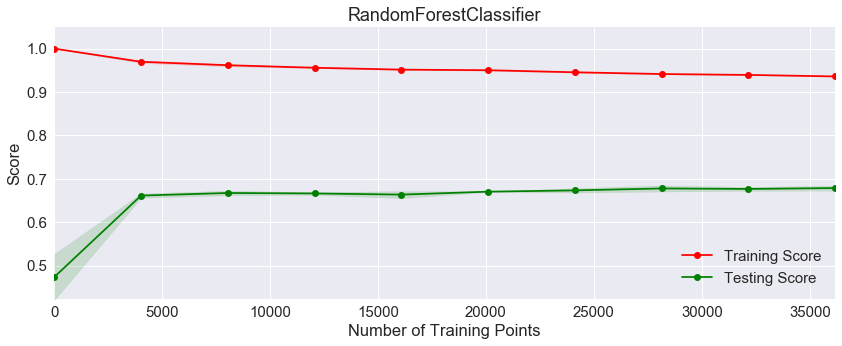

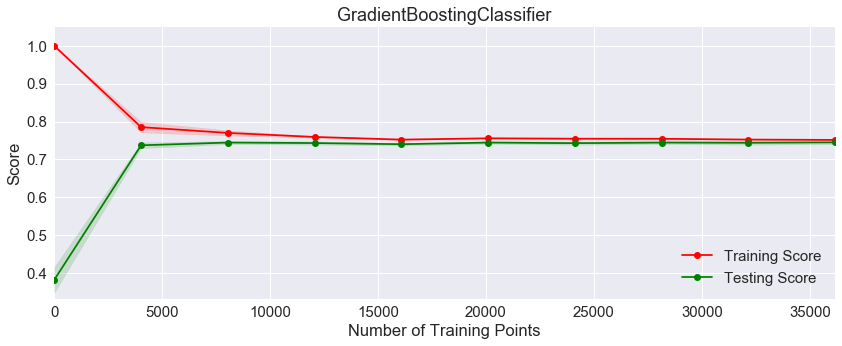

Wall time: 2min 23s


In [12]:
%%time

cv = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 0)
train_sizes = np.rint(np.linspace(10, X.shape[0]*0.8 - 1, 10)).astype(int)

ModelLearning(X, y, GaussianNB(), cv, scoring, train_sizes)
ModelLearning(X, y, RandomForestClassifier(random_state = 0), cv, scoring, train_sizes)
ModelLearning(X, y, GradientBoostingClassifier(random_state = 0), cv, scoring, train_sizes)

## Dimensionality Reduction

Dataframe Shape (after dimensionality reduction): (36177, 103)
Wall time: 8.54 s


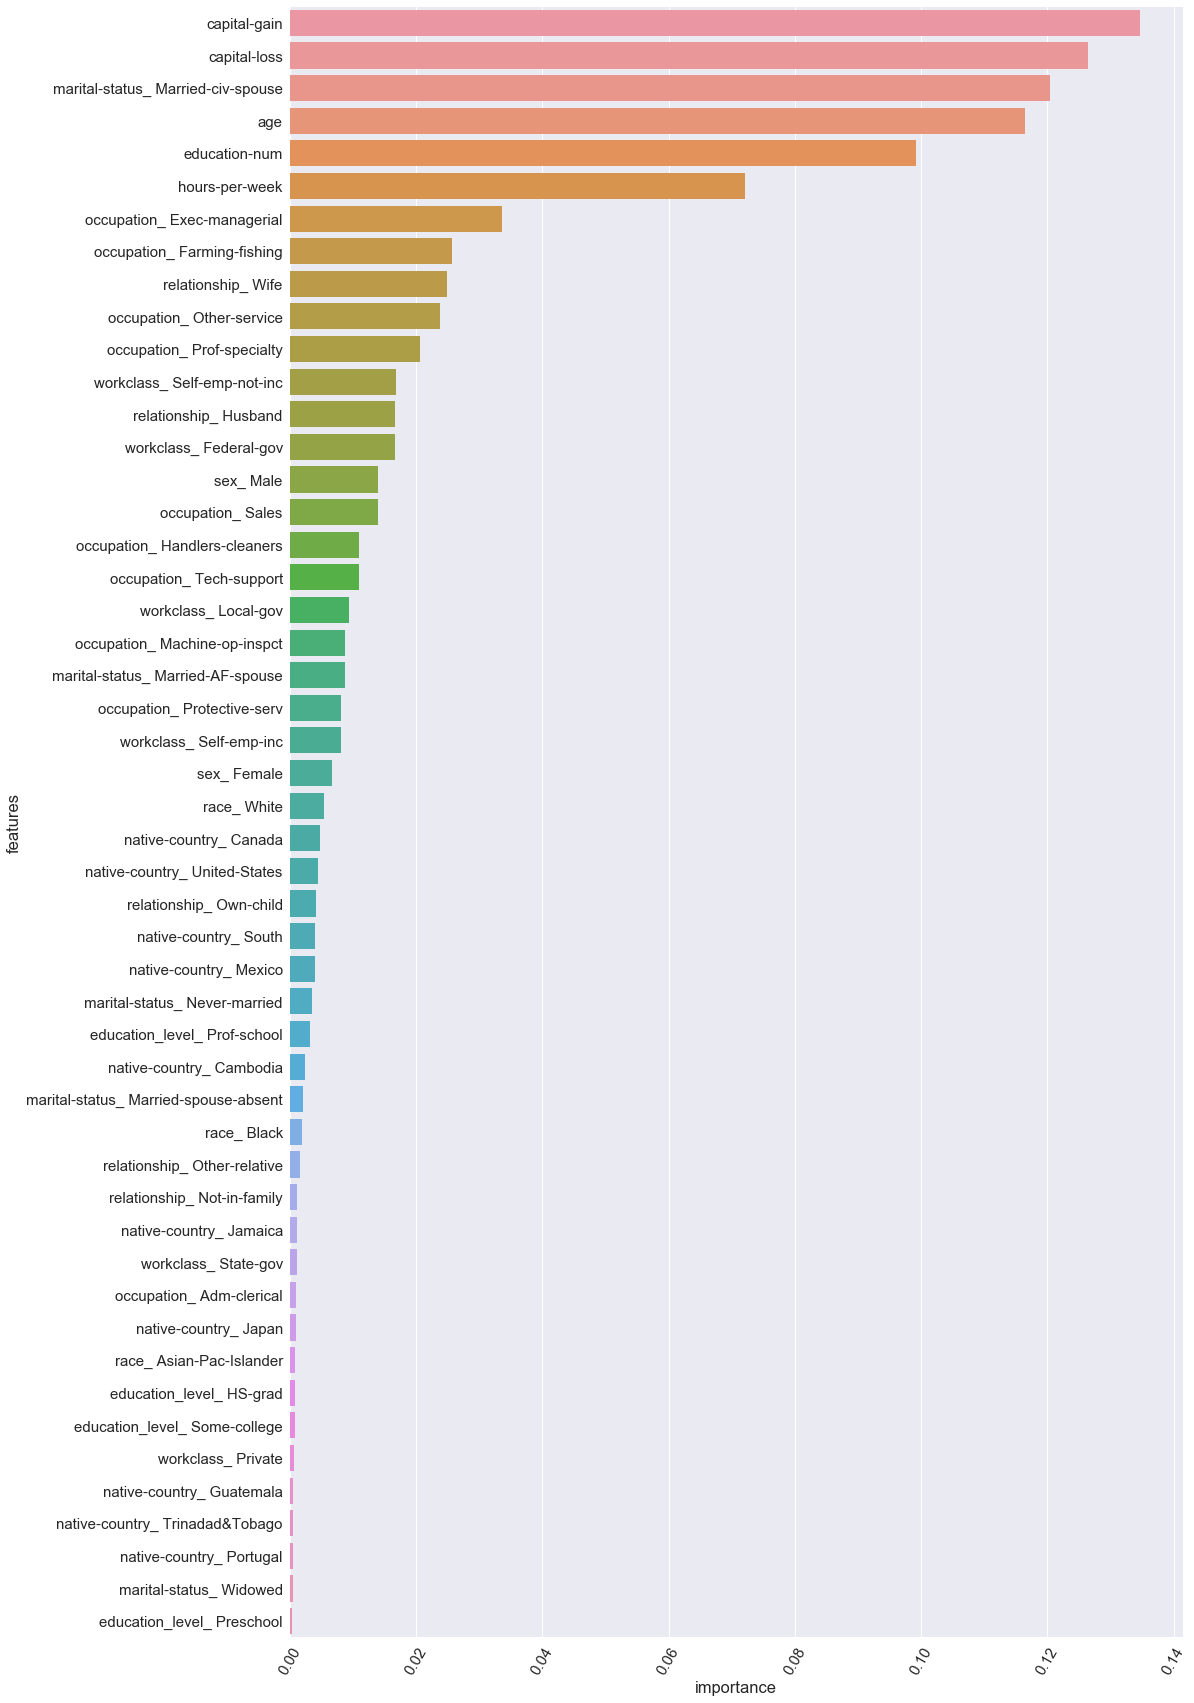

In [13]:
%%time

clf = GradientBoostingClassifier(random_state = 0)
clf = clf.fit(X_train,y_train)
importances = clf.feature_importances_

max_features = np.count_nonzero(importances)

features = pd.DataFrame()
features['features'] = X_train.columns
features['importance'] = importances
features.sort_values(by=['importance'],ascending=False,inplace=True)

print('Dataframe Shape (after dimensionality reduction):',X_train.shape)
fig,ax= plt.subplots()
fig.set_size_inches(16,30)
plt.xticks(rotation=60)
sns.set(font_scale=2.5)
sns.barplot(data=features.head(max_features),x="importance",y="features",ax=ax) #,orient="v")
sns.set(font_scale=1.5)

X_train = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:max_features]]]
X_test = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:max_features]]]

## Creating a Training and Predicting Pipeline

In [14]:
def train_predict(clf, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time()
    clf = clf.fit(X_train[:sample_size], y_train[:sample_size])
    results['train_time'] = time() - start
        
    start = time() 
    pred_train = clf.predict(X_train[:sample_size]) # 300
    pred_test = clf.predict(X_test)
    results['pred_time'] = time() - start
            
    results['acc_train'] = accuracy_score(y_train[:sample_size], pred_train) # 300
    results['acc_test'] = accuracy_score(y_test, pred_test)
    
    results['f_train'] = fbeta_score(y_train[:sample_size], pred_train, beta=0.5) # 300
    results['f_test'] = fbeta_score(y_test, pred_test, beta=0.5)
       
    print("{} trained on {} samples.".format(clf.__class__.__name__, sample_size))
        
    return results

## Initial Model Evaluation

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


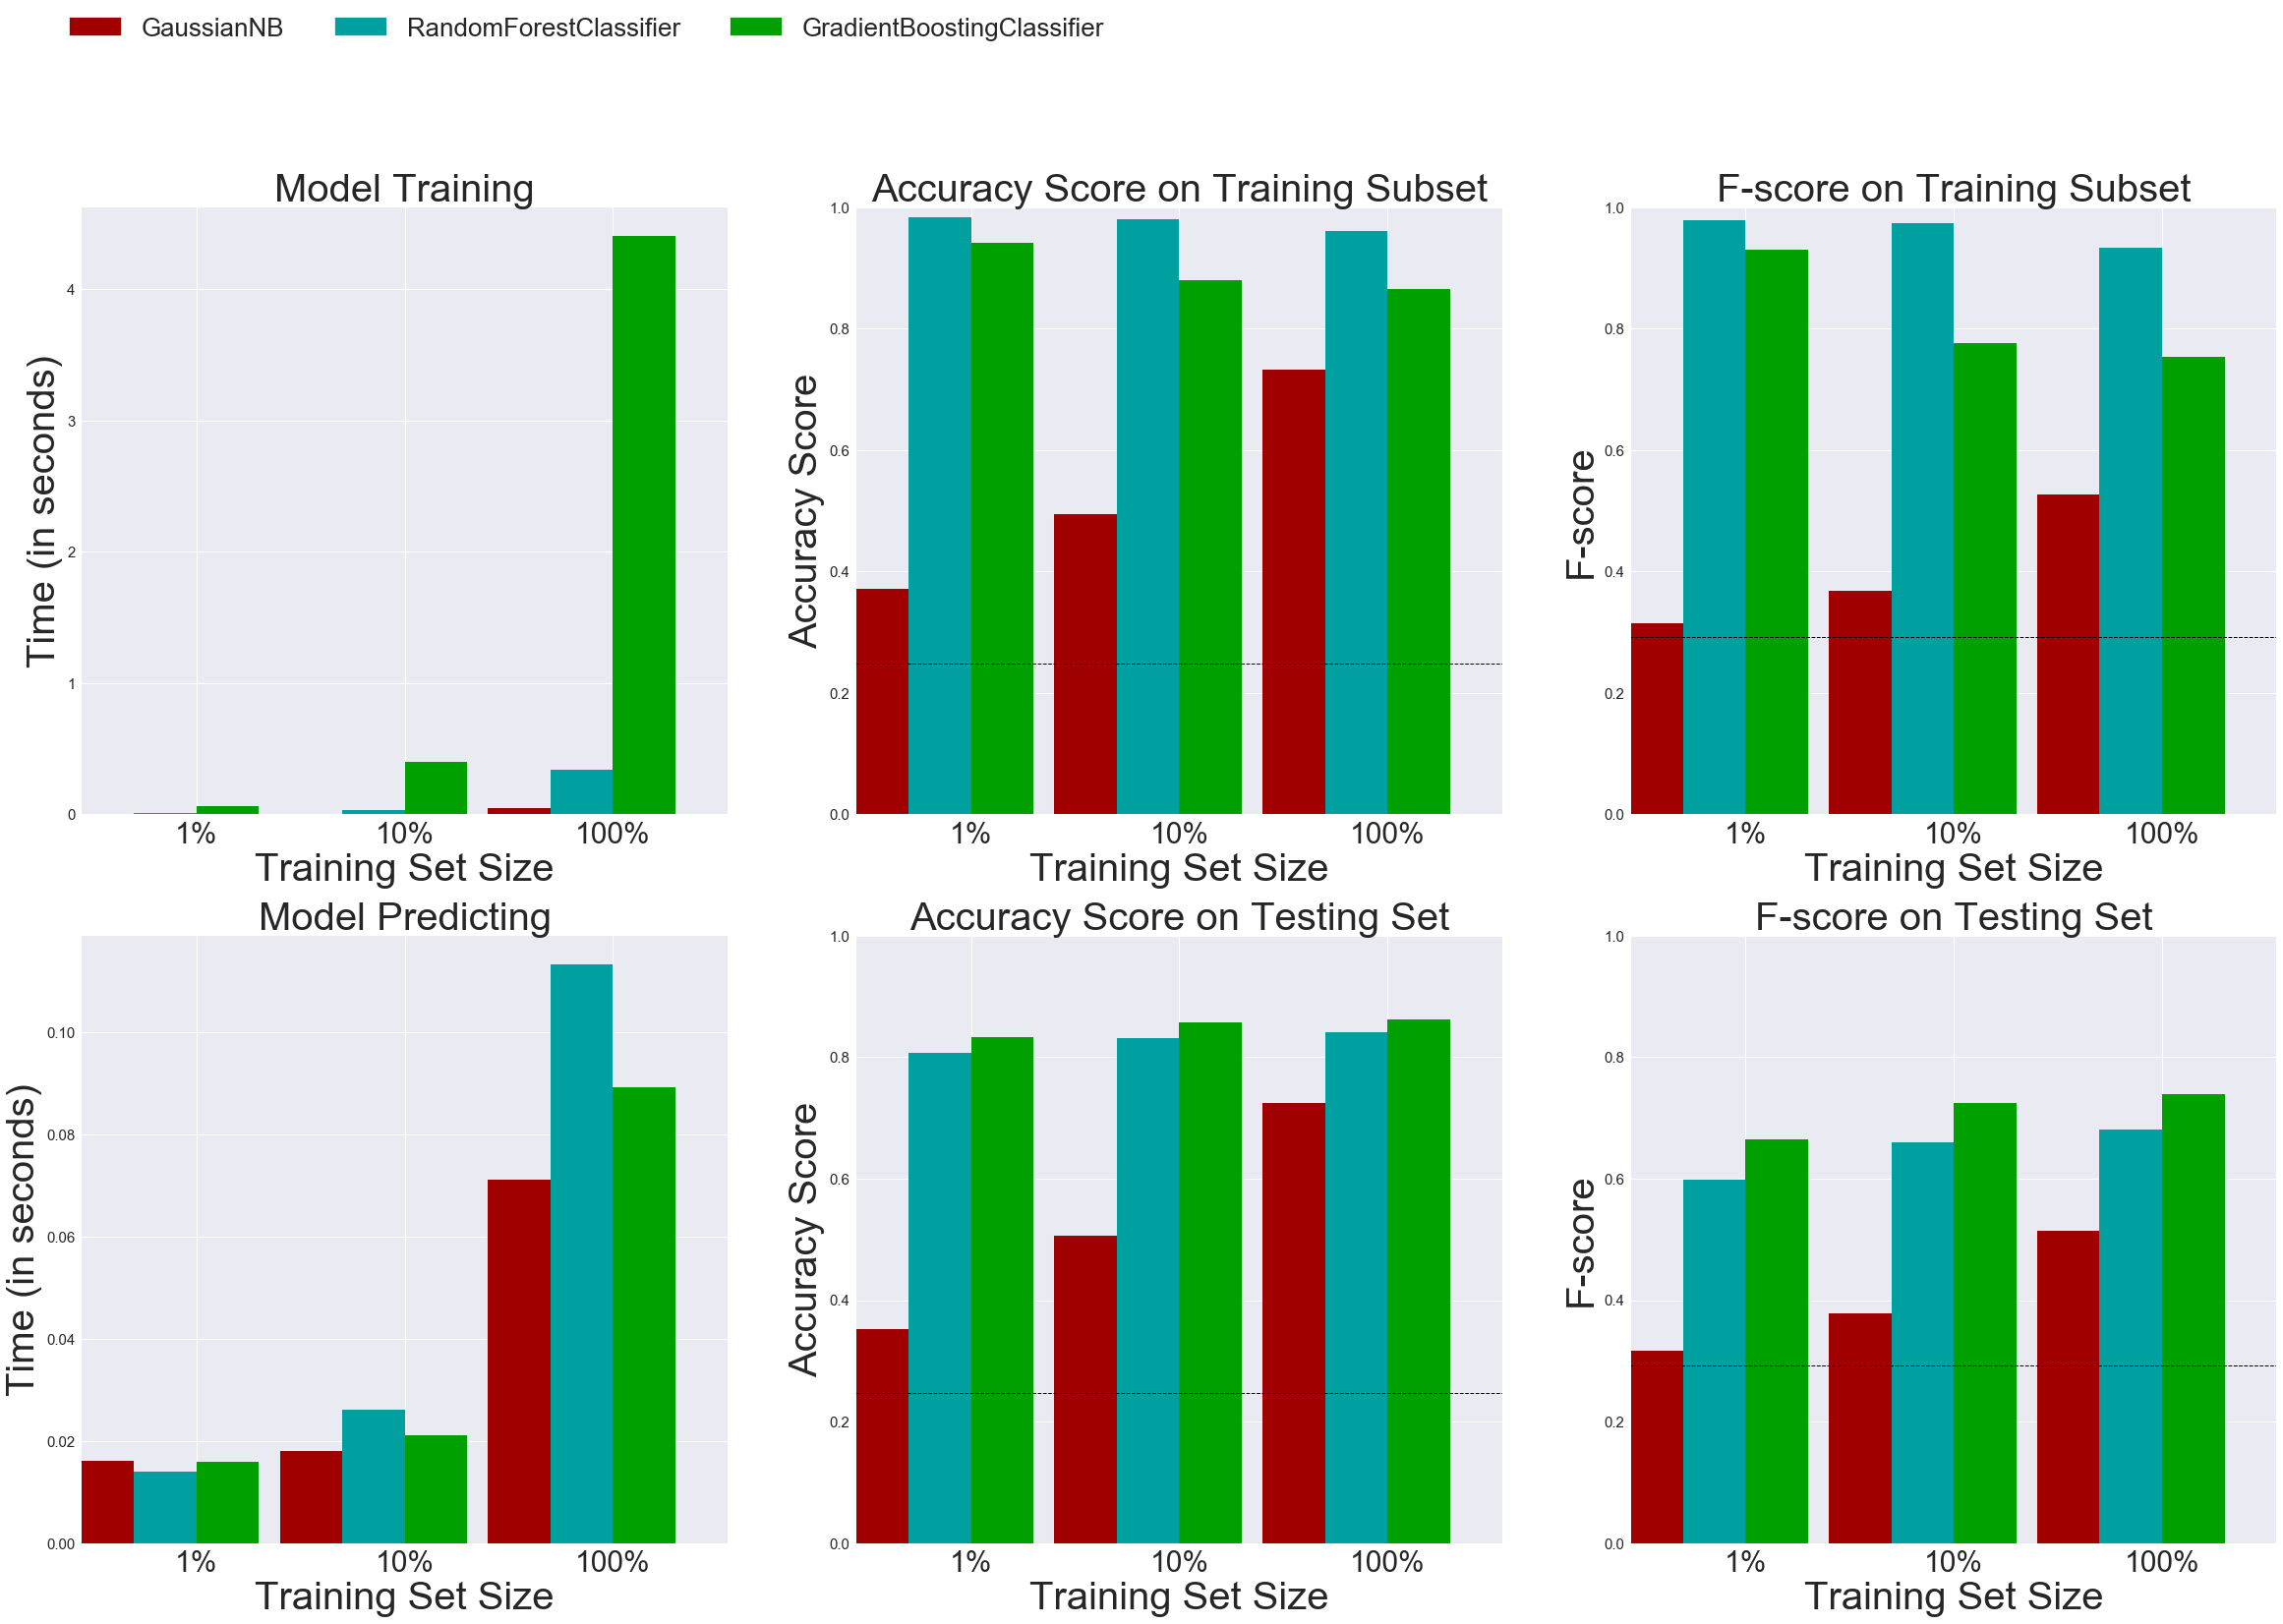

Wall time: 6.65 s


In [15]:
%%time

%run ./visuals.py

sns.set(font_scale=1.5)
clf_A = GaussianNB()
clf_B = RandomForestClassifier(random_state = 0)
clf_C = GradientBoostingClassifier(random_state = 0)

samples_100 = int(len(X_train))   # 100% sample
samples_10 = int(len(X_train)/10) # 10% sample
samples_1 = int(len(X_train)/100) # 1% sample

results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

evaluate(results, accuracy, fscore)

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer: **

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer: ** 

## Complexity Curves

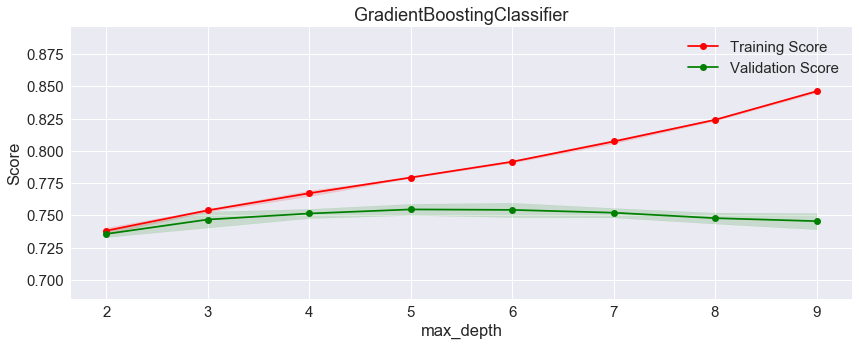

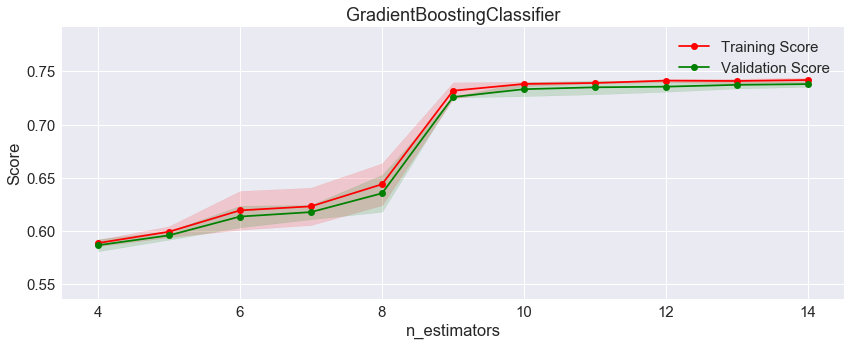

Wall time: 4min 4s


In [16]:
%%time

cv = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 0)

clf = GradientBoostingClassifier(random_state = 0)
ModelComplexity(X_train, y_train, clf, cv, scoring, 'max_depth', np.arange(2,10,1))

clf = GradientBoostingClassifier(max_depth = 5, random_state = 0)
ModelComplexity(X_train, y_train, clf, cv, scoring, 'n_estimators', np.arange(4,15,1))

## Model Tuning

In [17]:
%%time

def fit_model(X_train, y_train, X_test, clf, cv, scoring, param_grid):
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    print("Unoptimized model\n------")
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
    
    grid = GridSearchCV(clf, param_grid=param_grid, scoring=scoring, cv=cv)
    grid = grid.fit(X_train, y_train)
    
    best_clf = grid.best_estimator_
    best_predictions = best_clf.predict(X_test)
    print("\nOptimized Model\n------")
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)),'\n')
    
    print(best_clf,'\n')
    return best_clf, best_predictions

cv = StratifiedShuffleSplit(n_splits = 3, test_size = 0.20, random_state = 0)
param_grid = {#'min_samples_leaf' : np.arange(1,20,5), 
              #'min_samples_split' : np.arange(2,60,15),
              'max_depth': np.arange(6,11,1),
              'n_estimators': np.arange(8,13,1)}

clf = GradientBoostingClassifier(random_state = 0) 
best_clf, best_predictions = fit_model(X_train, y_train, X_test, clf, cv, scoring, param_grid)

Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8609
Final F-score on the testing data: 0.7489 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=12,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False) 

Wall time: 2min 49s


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |                   |                 |
| F-score        |                   |   EXAMPLE       |


**Answer: **

## Feature Importance and Feature Selection

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

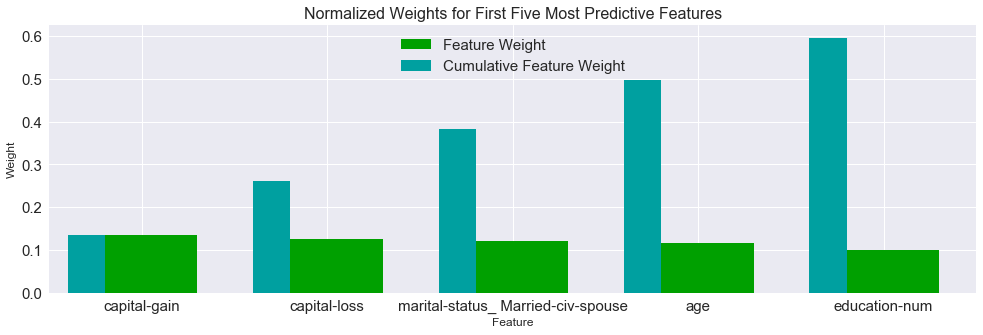

Final Model trained on full data
------
Accuracy on testing data: 0.8609
F-score on testing data: 0.7489

Final Model trained on reduced data
------
Accuracy on testing data: 0.8534
F-score on testing data: 0.7268
Wall time: 4.6 s


In [18]:
%%time

''' Feature Importance '''
clf = GradientBoostingClassifier(random_state = 0)
clf = clf.fit(X_train,y_train)
importances = clf.feature_importances_
feature_plot(importances, X_train, y_train)

''' Feature Selection '''
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

''' Train on the "best" model found from grid search earlier '''
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
reduced_predictions = clf.predict(X_test_reduced)

print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

## Sensitivity Analysis

In [1]:
def SensitivityAnalysis(X, y, fit_model, client_data):
    prices = []

    for k in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = k)

        reg = fit_model(X_train, y_train)
        pred = reg.predict([client_data])[0]
        prices.append(pred)

        print ("Trial {}: ${:,.2f}".format(k+1, pred))
    print ("\nRange in prices: ${:,.2f}".format(max(prices) - min(prices)))
    print ("Standard Deviation in prices: ${:,.2f}".format(np.std(prices)))
    
#SensitivityAnalysis(X, y, fit_model, client_data[0])